[LAB 10] 7. 대응표본 T 검정 (Pairted T test)

- 표본의 각 사례마다 대응하는 2개의 관측치를 통해 판단

- 한 집단에 어떤 작용이 가해졌을 때에 대한 before, after를 비교‘related samples t-test’ 또는 ’paired samples t-test’로 부른다.

- statannotations 패키지가 seaborn 0.12 이하 버전만 지원한다. 현재 seaborn의 최
신 버전은 0.13

### #01.준비작업
#### [1] 준비작업

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt
from scipy.stats import t, normaltest, bartlett, levene, ttest_rel, mannwhitneyu
from statannotations.Annotator import Annotator

#### [2] 그래프 초기화

In [3]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

### #02. 예제 (1) - 사슴의 다리 길이 비교
사슴의 왼쪽 앞다리와 왼쪽 뒷다리의 길이를 측정한 자료를 통해 두 다리의 길이(cm)가 같은지
다른지 알고 싶다.

이 경우 한 사슴에 대하여 두 다리 길이를 측정하였으므로 사슴은 독립이지만 한 마리의 사슴의
일부인 두 다리는 독립이 아니다.

#### [1] 데이터 가져오기

In [4]:
origin = load_data('deer')
origin

[data] https://data.hossam.kr/data/lab10_/deer.xlsx
[desc] 사슴의 왼쪽 앞다리와 왼쪽 뒷다리의 길이를 측정한 자료 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata


,사슴,앞다리,뒷다리
0,1,138,142
1,2,136,140
2,3,147,144
3,4,139,144
4,5,143,142
5,6,141,146
6,7,143,149
7,8,145,150
8,9,136,142
9,10,146,148


#### [2] 신뢰구간 확인
두 변수의 데이터 분포와 신뢰구간을 확인한다

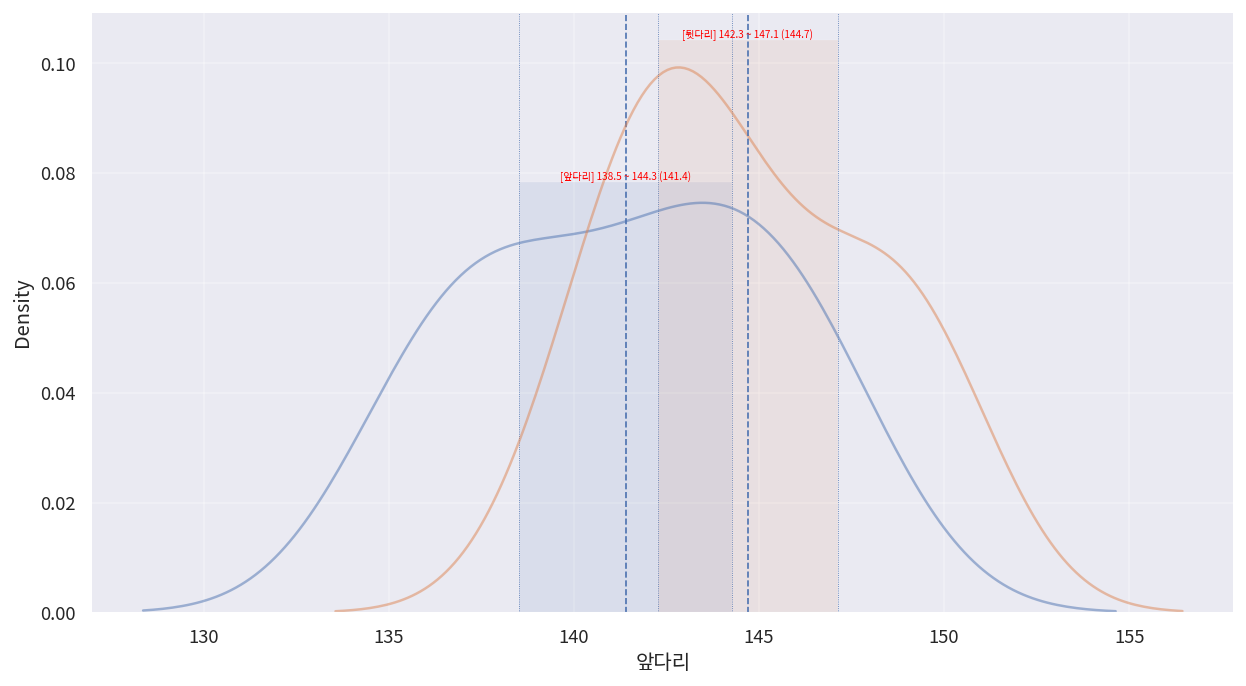

In [5]:
data = origin[['앞다리','뒷다리']]                # 확인할 데이터

# 1) 그래프 초기화
width_px  = 1280                      # 그래프 가로 크기
height_px = 720                       # 그래프 세로 크기
rows = 1                              # 그래프 행 수
cols = 1                              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max = data[c].max()               # 최대값
    clevel = 0.95                     # 신뢰수준
    dof = len(data[c]) - 1            # 자유도
    sp_mean = data[c].mean()          # 표본평균
    sp_std = data[c].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c]))  # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} ({sp_mean:.1f})",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()      # 여백 제거
plt.show()              # 그래프 화면 출력
plt.close()             # 그래프 작업 종료


> 두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있따.
> 또한 두 그룹 모두 표본 평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다

#### [3] 가설검정의 가정 확인


In [8]:
# 검사하려는 데이터 추출
data = origin[['앞다리', '뒷다리']]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s, p = normaltest(data[c])

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"               # 정규성을 충족할 경우의 검정방법
        s, p = bartlett(*data.values.T)   # 모든 컬럼의 데이터를 한 번에 전달
    else:
        n = "Levene"                 # 정규성을 충족하지 않을 경우의 검정방법
        s, p = levene(*data.values.T, center="median")

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index("field")
report_df


,statistic,p-value,result
field,,,
앞다리,1.824001,0.401720,True
뒷다리,1.376960,0.502339,True
Bartlett,0.340678,0.559438,True


#### [4] 사슴의 앞다리와 뒷다리의 길이가 다른지 검정
| 구분        | 수식                     | 내용                                  |
|-------------|---------------------------|----------------------------------------|
| 앞다리      | μ(앞다리)                 |                                        |
| 뒷다리      | μ(뒷다리)                 |                                        |
| 귀무가설(H₀) | μ(앞다리) = μ(뒷다리)      | 사슴의 앞다리와 뒷다리 길이에는 차이가 없다 |
| 대립가설(H₁) | μ(앞다리) ≠ μ(뒷다리)      | 사슴의 앞다리와 뒷다리 길이에는 차이가 있다 |

두 그룹간의 평균을 비교하기 위해 alternative 파라미터를 two sided 로 설정한다

In [9]:
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'],alternative = 'two-sided') #alternative='less' / 'greater'
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.008, 대립가설 채택'

> 차이값에 대한 t 통계량의 값이 -3.414 이고, 이에 대응되는 유의 확률이 0.008 이므로 귀무가설을 기각하고 대립가설을 채택한다. 즉 사슴의 앞다리와 뒷다리의 길이에는 차이가 있다고 결론 내릴 수 있다

#### [5] 앞다리가 뒷다리보다 더 긴지 검정
| 구분        | 수식           | 내용                             |
|-------------|----------------|----------------------------------|
| 귀무가설(H₀) | μ(B) ≤ μ(G)    | 사슴의 앞다리는 뒷다리보다 길지 않다 |
| 대립가설(H₁) | μ(B) > μ(G)    | 사슴의 앞다리는 뒷다리보다 길다     |


In [10]:
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'],alternative = 'greater') #alternative='less' / 'greater'
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.996, 귀무가설 채택'

> 차이값에 대한 t 통계량의 값이 -3.414 이고, 이에 대응되는 유의 확률이 0.996 이므로 귀무가설을 기각할 수 없다.
>
> 즉 앞다리는 뒷다리보다 길지 않다고 결론 내릴 수 있다

#### [6] 앞다리가 뒷다리보다 더 짧은지 검정
| 구분        | 수식         | 내용                           |
|-------------|--------------|--------------------------------|
| 귀무가설(H₀) | μ(B) ≥ μ(G)  | 사슴의 앞다리는 뒷다리보다 짧지 않다 |
| 대립가설(H₁) | μ(B) < μ(G)  | 사슴의 앞다리는 뒷다리보다 짧다     |


In [11]:
s, p = ttest_rel(origin['앞다리'], origin['뒷다리'],alternative = 'less') #alternative='less' / 'greater'
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -3.414, p-value: 0.004, 대립가설 채택'

> 차이값에 대한 t 통계량의 값이 -3.414 이고, 이에 대응되는 유의 확률이 0.004 이므로 귀무가설을 기각하고 대립가설을 채택한다
>
> 즉 사슴의 앞다리는 사슴의 뒷다리보다 짧다고 할 수 있다

#### [7] 가설검정 시각화

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

앞다리 vs. 뒷다리: t-test paired samples, P_val:7.703e-03 t=-3.414e+00


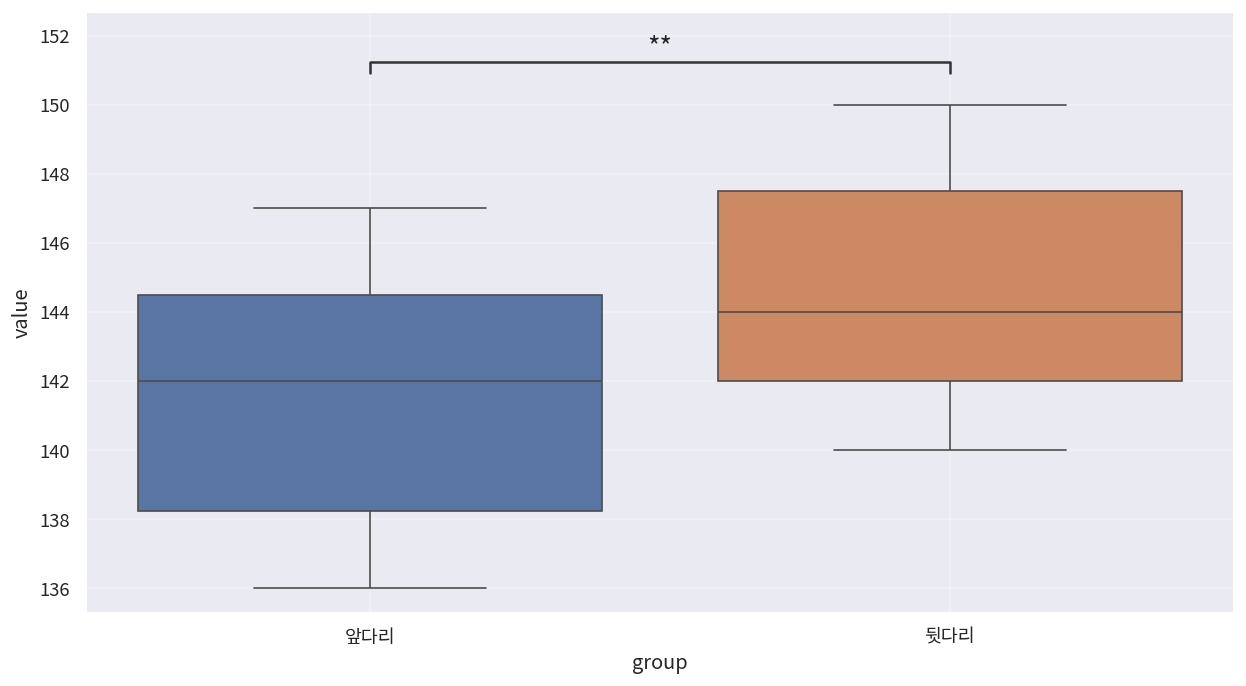

In [12]:
# 검정할 데이터 필드명
fields = ['앞다리', '뒷다리']

# 검정 방법
#  `t-test_ind`, `t-test_paired`, `t-test_welch`, `Mann-Whitney`,
#  `Mann-Whitney-gt`, `Mann-Whitney-ls`, `Levene`, `Wilcoxon`, `Kruskal`
test_method = 't-test_paired'

# 데이터 재배치
df = melt(origin[fields], value_vars=fields, var_name='group', value_name='value')

# 1) 그래프 초기화
width_px = 1280                      # 그래프 가로 크기
height_px = 720                      # 그래프 세로 크기
rows = 1                             # 그래프 행 수
cols = 1                             # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) BoxPlot 그리기
sb.boxplot(data=df, x='group', y='value', hue='group')

annotator = Annotator(ax, data=df, x='group', y='value',
                      pairs=[fields])
annotator.configure(test=test_method)
annotator.apply_and_annotate()

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)             # 배경 격자 표시

# 4) 출력
plt.tight_layout()                   # 여백 제거
plt.show()                           # 그래프 화면 출력
plt.close()                          # 그래프 작업 종료


### #03 예제 (2) - 자동차 첨가제가 주행거리에 미치는 영향
다섯 종류의 새 차에 대하여 같은 종류의 차 두 대 중에서 한 대를 랜덤하게 선택하여 첨가제를 사용하고, 다른 한 대에는 첨가제를 사용하지 않고 같은 운전자가 같은 장소에서 운전한 결과 다음과 같은 자료를 얻었다.
첨가제를 사용하면 주행거리가 늘어난다고 할 수 있는지 유의수준 5%에서 검정하여 보라.


> 그룹 A : 첨가제를 사용한 경우, 그룹 B : 첨가제를 사용하지 않은 경우

#### [1] 데이터 가져오기

In [13]:
origin =load_data('oil')
origin

[data] https://data.hossam.kr/data/lab10_/oil.xlsx
[desc] 다섯 종류의 새 차에 대하여 같은 종류의 차 두 대 중에서 한 대를 랜덤하게 선택하여 첨가제를 사용하고, 다른 한 대에는 첨가제를 사용하지 않고 같은 운전자가 같은 장소에서 운전한 후 주행거리를 측정한 결과 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata


,그룹A,그룹B
0,13.2,11.8
1,13.1,13.9
2,16.3,12.1
3,14.9,10.5
4,14.2,9.3
5,16.1,16.3
6,15.1,15.1
7,13.6,12.3
8,15.8,11.6
9,14.2,8.4


#### [2] 신뢰구간 확인

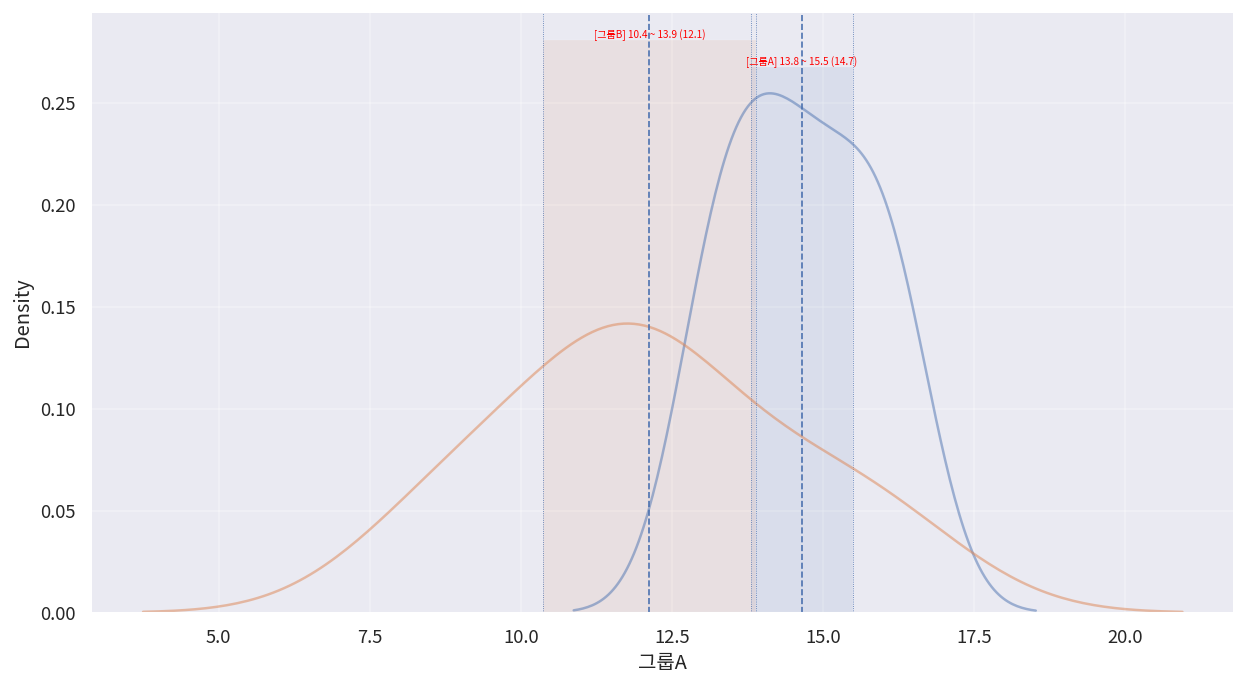

In [14]:
data = origin[['그룹A','그룹B']]                # 확인할 데이터

# 1) 그래프 초기화
width_px  = 1280                      # 그래프 가로 크기
height_px = 720                       # 그래프 세로 크기
rows = 1                              # 그래프 행 수
cols = 1                              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max = data[c].max()               # 최대값
    clevel = 0.95                     # 신뢰수준
    dof = len(data[c]) - 1            # 자유도
    sp_mean = data[c].mean()          # 표본평균
    sp_std = data[c].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c]))  # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} ({sp_mean:.1f})",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()      # 여백 제거
plt.show()              # 그래프 화면 출력
plt.close()             # 그래프 작업 종료


> 두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할수 있다
>또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다

#### [3] 가설검정 가정 확인

In [15]:
# 검사하려는 데이터 추출
data = origin[['그룹A', '그룹B']]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s, p = normaltest(data[c])

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"               # 정규성을 충족할 경우의 검정방법
        s, p = bartlett(*data.values.T)   # 모든 컬럼의 데이터를 한 번에 전달
    else:
        n = "Levene"                 # 정규성을 충족하지 않을 경우의 검정방법
        s, p = levene(*data.values.T, center="median")

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index("field")
report_df


,statistic,p-value,result
field,,,
그룹A,1.803522,0.405854,True
그룹B,0.151115,0.927227,True
Bartlett,4.272571,0.038732,False


> 데이터가 정규성을 만족하지만 등분산성은 만족하지 않는다

#### [4] 두 그룹의 주행거리가 차이가 있는지 검정
> 데이터가 등분산성을 만족하지 않을 경우 mannwhitneyu 함수를 사용하여 Mann-Whitney U 검정을 시행한다

| 구분              | 수식        | 내용                                                         |
|-------------------|-------------|--------------------------------------------------------------|
| 그룹A의 주행거리 평균 | μ(A)        |                                                              |
| 그룹B의 주행거리 평균 | μ(B)        |                                                              |
| 귀무가설(H₀)        | μ(A) = μ(B) | 그룹A와 그룹B의 주행거리에는 차이가 없다. <br>즉, 실험에 사용된 첨가제는 주행거리에 영향을 주지 않는다. |
| 대립가설(H₁)        | μ(A) ≠ μ(B) | 그룹A와 그룹B의 주행거리에는 차이가 있다. <br>즉, 실험에 사용된 첨가제는 주행거리에 영향을 준다. |



In [16]:
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B']) #alternative='less' / 'greater'
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.021, 대립가설 채택'

> 대응표본 검정결과에서 P 값이 0.01로 유의수준 0.05보다 작으므로 차이가 없다는 귀무가설을 기각하고, 대립가설을 채택한다
>
> 따라서 첨가제를 사용하는 경우 주행거리에 차이가 있다고 판단한다

#### [6] 그룹 A 의 주행거리가 그룹 B 의 주행거리보다 긴지 검정

| 구분          | 수식        | 내용                                                                 |
|---------------|-------------|----------------------------------------------------------------------|
| 귀무가설(H₀)   | μ(A) ≤ μ(B) | 그룹A의 주행거리는 그룹B의 주행거리보다 길지 않다. 첨가제는 주행거리를 늘리는 데 효과가 없다. |
| 대립가설(H₁)   | μ(A) > μ(B) | 그룹A의 주행거리는 그룹B의 주행거리보다 길다. 첨가제는 주행거리를 늘리는 데 효과가 있다.     |


In [18]:
s, p = mannwhitneyu(origin['그룹A'], origin['그룹B'],alternative = 'greater') #alternative='less' / 'greater'
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.000, p-value: 0.010, 대립가설 채택'

> 대응표본 검정결과에서 p 값이 0.010 으로 유의수준 0.05 보다 작으므로 첨가제를 넣은 그룹의 주행거리가 첨가제를 넣지 않은 그룹의 주행거리보다 길지 않다는 귀무가설을 기각하고 대립가설을 채택한다
> 즉, 첨가제를 넣은 A 그룹의 주행거리가 더 길기 떄문에 실험에 사용된 첨가제는 주행거리의 연장에 효과가 있다고 볼 수 있다

### [7] 가설검정 시각화

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test greater, P_val:1.049e-02 U_stat=8.100e+01


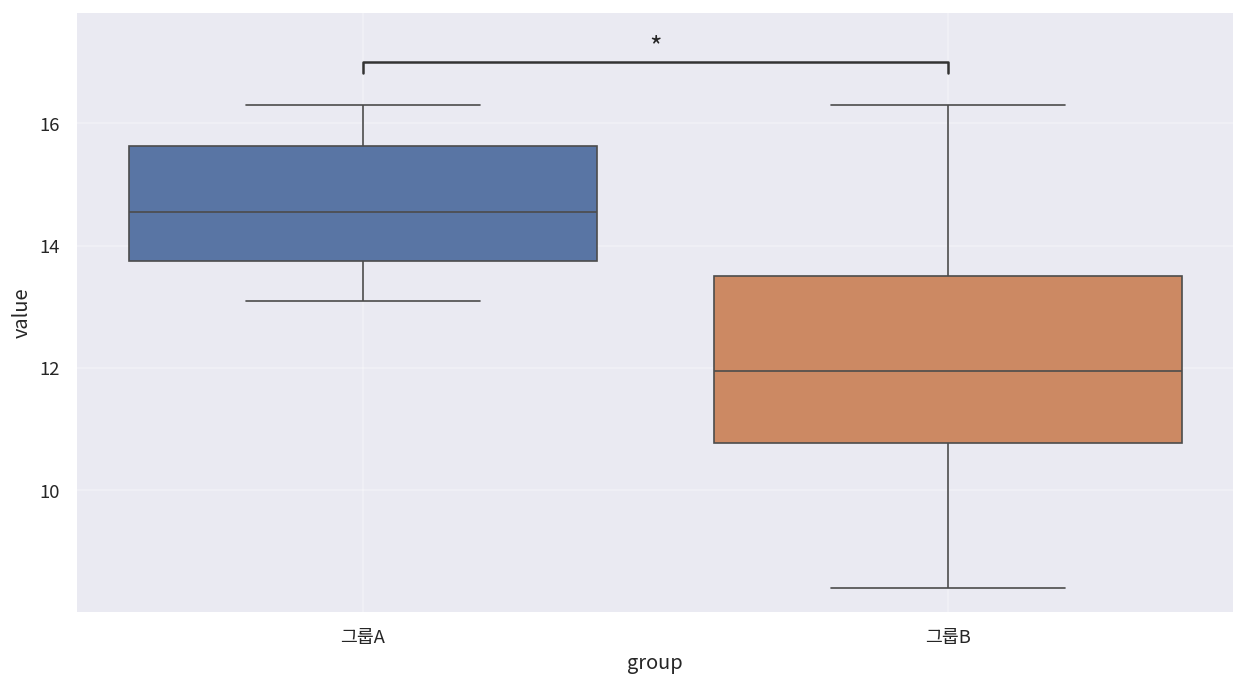

In [19]:
# 검정할 데이터 필드명
fields = ['그룹A', '그룹B']

# 검정 방법
#  `t-test_ind`, `t-test_paired`, `t-test_welch`, `Mann-Whitney`,
#  `Mann-Whitney-gt`, `Mann-Whitney-ls`, `Levene`, `Wilcoxon`, `Kruskal`
test_method = 'Mann-Whitney-gt'

# 데이터 재배치
df = melt(origin[fields], value_vars=fields, var_name='group', value_name='value')

# 1) 그래프 초기화
width_px = 1280                      # 그래프 가로 크기
height_px = 720                      # 그래프 세로 크기
rows = 1                             # 그래프 행 수
cols = 1                             # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) BoxPlot 그리기
sb.boxplot(data=df, x='group', y='value', hue='group')

annotator = Annotator(ax, data=df, x='group', y='value',
                      pairs=[fields])
annotator.configure(test=test_method)
annotator.apply_and_annotate()

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)             # 배경 격자 표시

# 4) 출력
plt.tight_layout()                   # 여백 제거
plt.show()                           # 그래프 화면 출력
plt.close()                          # 그래프 작업 종료
